# --------------- Fair comparison With other Deep Learning Models  ---------------

In [22]:
# Import necessary libraries
import osr
import cv2
import seaborn
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Input, optimizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision import datasets, transforms, models
from PIL import Image
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, GlobalAveragePooling2D, Reshape, Dense, multiply, Lambda
from keras.optimizers import Adam
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, \
     precision_recall_curve

In [23]:
train_dir = r'C:\Users\伺龙\Desktop\Gender\data\gender\train'
test_dir = r'C:\Users\伺龙\Desktop\Gender\data\gender\test'
valid_dir = r'C:\Users\伺龙\Desktop\Gender\data\gender\valid'

In [24]:
# Load and preprocess the training data
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(112, 112),
    batch_size=16,
    class_mode='categorical',  # Assuming labels are provided as integers
    color_mode='rgb'  # Assuming images are grayscale
)

Found 3491 images belonging to 2 classes.


In [25]:
# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(112, 112),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

Found 200 images belonging to 2 classes.


In [26]:
# Load and preprocess the valid data
valid_datagen = ImageDataGenerator(rescale=1.0/255)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(112, 112),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

Found 200 images belonging to 2 classes.


In [27]:
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()
x_valid, y_valid = valid_generator.next()

## ----------------------------------------- Use Pre-trained model VGG16 -----------------------------------------

In [28]:
# Load pre-trained VGG16 model (excluding top layers)
model = VGG16(include_top=False, weights='imagenet', input_shape=(112, 112, 3))

In [29]:
# Add custom top layers for classification
x = Flatten()(model.output)
x = Dense(64, activation='relu')(x)
x = layers.Dropout(rate=0.1)(x)
output = Dense(2, activation='softmax')(x)

In [30]:
#computing attention weights. Each element in the input tensor x will be assigned a weight by this dense layer
attention = Dense(1, activation='tanh')(x)

In [31]:
# Reshape attention to have dimensions (-1, 1, 1)
#(batch size, height, width, channel(axis = -2))
#4D tensor
attention = Reshape((-1, 1, 1))(attention)

In [32]:
# Apply the attention weights element-wise to the original feature representation (x) 
attention = multiply([x, attention])

In [33]:
# The attention weights are summed along the channel axis (-2) to produces a single attention value 
attention = Lambda(lambda x: K.sum(x, axis=-2))(attention)

In [34]:
# The attention values are expanded along a new axis (-1)
attention = Lambda(lambda x: K.expand_dims(x, axis=-1))(attention)

In [35]:
# computes the average of all the values along each channel
attention = GlobalAveragePooling2D()(attention)

In [36]:
merged = Dense(2, activation='softmax')(attention)

In [37]:
# Create the new model
model = Model(inputs= model.input, outputs=merged)

In [38]:
# Freeze base layers to prevent their weights from being updated
for layer in model.layers:
    layer.trainable = False

In [39]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 112, 112, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 112, 112, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           block1_conv2[0][0]               
_______________________________________________________________________________________

In [40]:
# Compile the model
model.compile(optimizer= optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
history=model.fit(x_train, y_train,batch_size=32, epochs=20,  validation_split=0.2)

Epoch 1/20
1/1 [==============================] - 0s 253ms/step - loss: 0.6816 - accuracy: 0.5833 - val_loss: 0.7265 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 58ms/step - loss: 0.6993 - accuracy: 0.4167 - val_loss: 0.7265 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 58ms/step - loss: 0.7053 - accuracy: 0.3333 - val_loss: 0.7265 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.7265 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 0.6955 - accuracy: 0.5000 - val_loss: 0.7265 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 56ms/step - loss: 0.7074 - accuracy: 0.3333 - val_loss: 0.7265 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 54ms/step - loss: 0.6923 - accuracy: 0.5000 - val_loss: 0.7265 - val_accuracy: 0.0000e+0

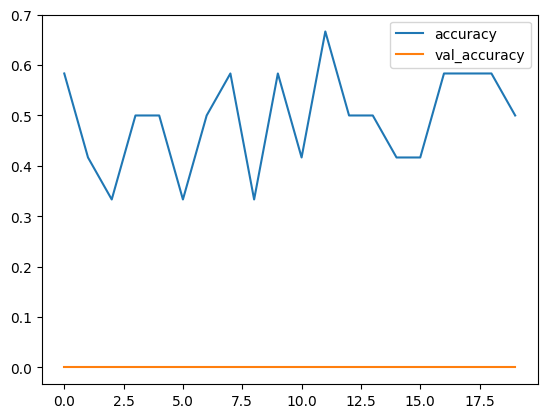

In [42]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

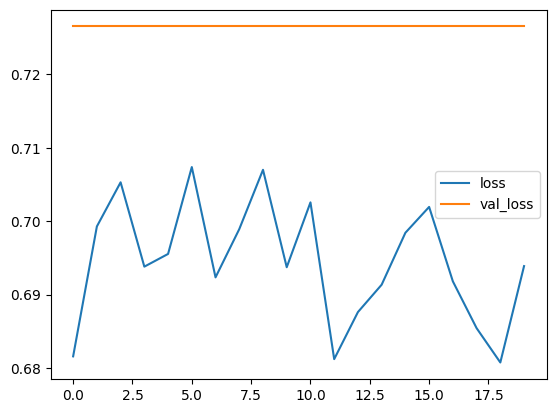

In [43]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [44]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

1/1 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.6250
Test accuracy: 0.625
Test loss: 0.6848284006118774


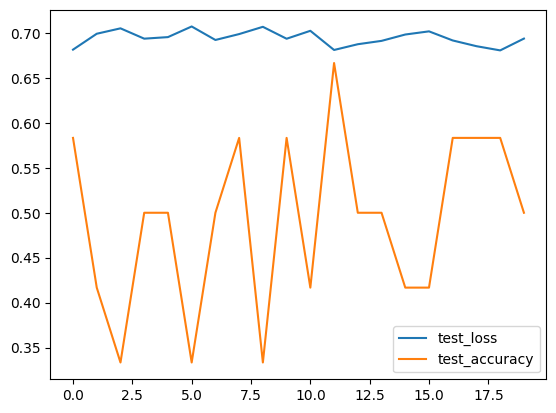

In [45]:
plt.plot(history.history['loss'], label='test_loss')
plt.plot(history.history['accuracy'], label='test_accuracy')
plt.legend()
plt.show()

In [46]:
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_argmax = np.argmax(y_test, axis=1) 

accuracy = accuracy_score(y_test_argmax, y_pred)
error= 1 - accuracy
recall = recall_score(y_test_argmax, y_pred, average='macro')
precision = precision_score(y_test_argmax, y_pred, average='macro')
f1 = f1_score(y_test_argmax, y_pred, average='macro')
cm = confusion_matrix(y_test_argmax, y_pred)
TP, FP, FN, TN = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
TPR = TP / (TP + FN)
TNR = TN / (FP + TN)

In [47]:
print(f"accuracy:{accuracy}")
print(f"error:{error}")
print(f"recall:{recall}")
print(f"precision:{precision}")
print(f"sensitivity:{TPR}")
print(f"specificity:{TNR}")
print(f"f1_score:{f1}")

accuracy:0.625
error:0.375
recall:0.6333333333333333
precision:0.625
sensitivity:0.5
specificity:0.75
f1_score:0.6190476190476191


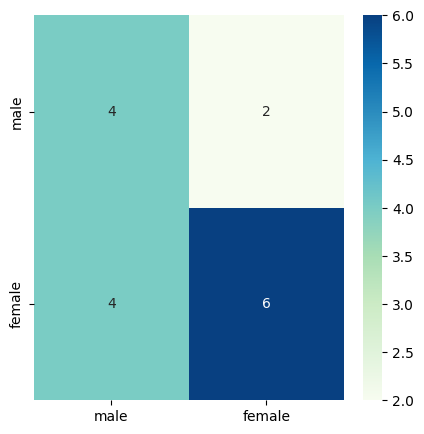

In [48]:
matrix = pd.DataFrame(cm, columns=["male", "female"], index=["male", "female"])
plt.figure(figsize=(5, 5))
seaborn.heatmap(matrix, cmap="GnBu", annot=True)
plt.show()

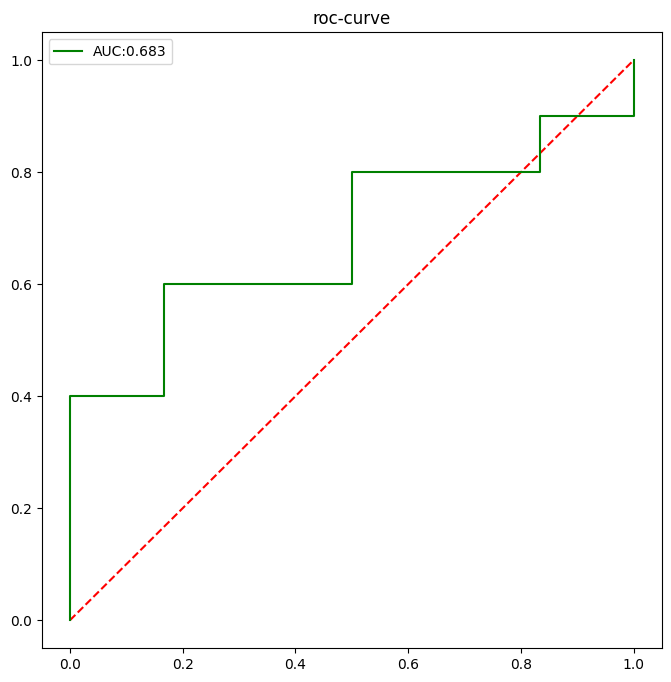

In [49]:
plt.figure(figsize=(8, 8))
fpr, tpr, _ = roc_curve(y_test_argmax, y_pred_prob[:, -1])
plt.plot([0, 1], [0, 1], "r--")
plt.plot(fpr, tpr, c="green", label=f"AUC:{auc(fpr, tpr):.3f}")
plt.legend()
plt.title("roc-curve")
plt.show() 

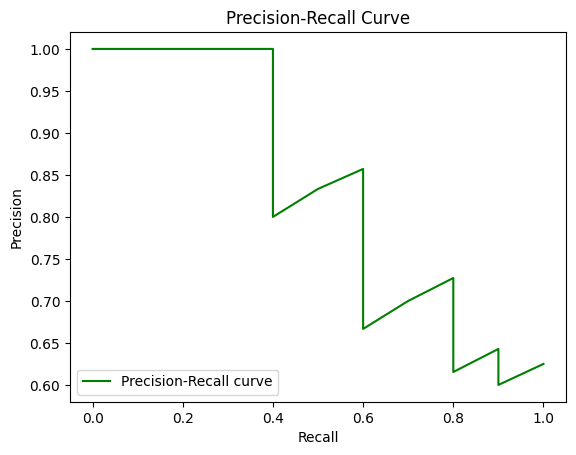

In [50]:
precision_vals, recall_vals, _ = precision_recall_curve(y_test_argmax, y_pred_prob[:, 1])
plt.figure()
plt.plot(recall_vals, precision_vals, label='Precision-Recall curve', c='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

## ----------------------------------------- Use Pre-trained model AlexNet -----------------------------------------

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler

In [52]:
train_transforms = transforms.Compose([
    transforms.Resize(112),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(112),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [53]:
train_dataset = datasets.ImageFolder(root=r'C:\Users\伺龙\Desktop\Gender\data\gender\train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root=r'C:\Users\伺龙\Desktop\Gender\data\gender\test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}

In [54]:
# Load pre-trained AlexNet model
alexnet = models.alexnet(pretrained=True)

D:\Anaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
D:\Anaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
for param in alexnet.parameters():
    param.requires_grad = False

num_ftrs = alexnet.classifier[6].in_features

alexnet.classifier[6] = nn.Linear(num_ftrs, 2) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

In [56]:
criterion = nn.CrossEntropyLoss()

In [57]:
optimizer = optim.Adam(alexnet.classifier[6].parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [58]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    model.to(device)
    
    val_labels_all = []
    val_preds_all = []
    val_probs_all = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    elif phase == 'val':
                        # Save the probabilities for ROC AUC
                        probs = torch.nn.functional.softmax(outputs, dim=1)
                        val_labels_all.append(labels.cpu().numpy())
                        val_preds_all.append(preds.cpu().numpy())
                        val_probs_all.append(probs.cpu().numpy())

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print('Training complete')

    # Concatenate all validation labels and predictions across all epochs
    val_labels_all = np.concatenate(val_labels_all)
    val_preds_all = np.concatenate(val_preds_all)
    val_probs_all = np.concatenate(val_probs_all)

    # Calculate validation metrics
    val_accuracy = accuracy_score(val_labels_all, val_preds_all)
    val_recall = recall_score(val_labels_all, val_preds_all)
    val_precision = precision_score(val_labels_all, val_preds_all)
    val_f1 = f1_score(val_labels_all, val_preds_all)
    val_cm = confusion_matrix(val_labels_all, val_preds_all)

    # Print validation metrics
    print(f'Validation Loss: {epoch_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation Precision: {val_precision:.4f}')
    print(f'Validation F1 Score: {val_f1:.4f}')
    print(f'Validation Confusion Matrix:\n{val_cm}')

    # Precision-recall curve
    precision, recall, _ = precision_recall_curve(val_labels_all, val_probs_all[:, 1])
    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')


Epoch 0/9
----------
train Loss: 0.5800 Acc: 0.7296
val Loss: 0.4040 Acc: 0.8000
Epoch 1/9
----------
train Loss: 0.5423 Acc: 0.7628
val Loss: 0.3325 Acc: 0.8600
Epoch 2/9
----------
train Loss: 0.4874 Acc: 0.7794
val Loss: 0.3514 Acc: 0.8800
Epoch 3/9
----------
train Loss: 0.5291 Acc: 0.7640
val Loss: 0.3514 Acc: 0.8750
Epoch 4/9
----------
train Loss: 0.4851 Acc: 0.7823
val Loss: 0.3168 Acc: 0.8800
Epoch 5/9
----------
train Loss: 0.4841 Acc: 0.7832
val Loss: 0.3078 Acc: 0.8700
Epoch 6/9
----------
train Loss: 0.4861 Acc: 0.7843
val Loss: 0.3120 Acc: 0.8650
Epoch 7/9
----------
train Loss: 0.4347 Acc: 0.8061
val Loss: 0.2916 Acc: 0.8900
Epoch 8/9
----------
train Loss: 0.4334 Acc: 0.8038
val Loss: 0.2891 Acc: 0.9050
Epoch 9/9
----------
train Loss: 0.4218 Acc: 0.8087
val Loss: 0.2844 Acc: 0.8950
Training complete
Validation Loss: 0.2844
Validation Accuracy: 0.8720
Validation Recall: 0.8490
Validation Precision: 0.8899
Validation F1 Score: 0.8690
Validation Confusion Matrix:
[[895 10

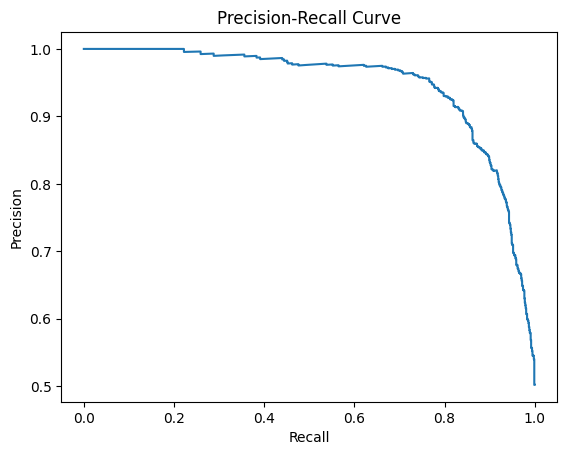

In [59]:
model_ft = train_model(alexnet, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

## ----------------------------------------- Use Inception model from slides -----------------------------------------

In [90]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D
from keras.optimizers import Adam
import keras.backend as K

In [91]:
def inception_block(input_shape, filter_1x1):
    
    # First branch
    branch_1_conv_1x1 = Conv2D(128, (1,1), padding='same', activation='relu')(input_shape)

    # Second branch
    branch_2_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_2_conv_3x3 = Conv2D(192, (3,3), padding='same', activation='relu')(branch_2_conv_1x1)
    branch_2_conv_1x1 = Conv2D(filter_1x1, (1,1), padding='same', activation='relu')(branch_2_conv_3x3)

    # Third branch
    branch_3_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_3_conv_5x5 = Conv2D(96, (5,5), padding='same', activation='relu')(branch_3_conv_1x1 )
    branch_3_conv_1x1 = Conv2D(128, (1,1), padding='same', activation='relu')(branch_3_conv_5x5)

    branch_output = concatenate([branch_1_conv_1x1, branch_2_conv_1x1, branch_3_conv_1x1], axis=-1)
    
    return branch_output

In [92]:
input_shape = Input(shape=(112,112,3))

In [93]:
x = Conv2D(64, (7,7), activation='relu')(input_shape)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = Conv2D(128, (1,1), activation='relu')(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)

In [94]:
model_1 = Model(inputs=input_shape, outputs=output)

In [95]:
model_1.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 106, 106, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 53, 53, 64)   0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 51, 51, 64)   36928       max_pooling2d_7[0][0]            
______________________________________________________________________________________

In [96]:
# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [97]:
history = model_1.fit(x_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
1/1 [==============================] - 1s 552ms/step - loss: 0.6964 - accuracy: 0.4167 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 117ms/step - loss: 0.6833 - accuracy: 0.5833 - val_loss: 0.7269 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 117ms/step - loss: 0.6746 - accuracy: 0.5833 - val_loss: 0.7375 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 116ms/step - loss: 0.6746 - accuracy: 0.5833 - val_loss: 0.7053 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 0s 116ms/step - loss: 0.6765 - accuracy: 0.5833 - val_loss: 0.7154 - val_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 0s 117ms/step - loss: 0.6728 - accuracy: 0.5833 - val_loss: 0.7433 - val_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 0s 118ms/step - loss: 0.6725 - accuracy: 0.5833 - val_loss: 0.7236 - val_accuracy: 0.5000
Epoch 8/20
1/1 [====

In [98]:
# Evaluate the model on the test set
test_loss, test_acc = model_1.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

1/1 [==============================] - 0s 997us/step - loss: 0.7450 - accuracy: 0.3750
Test accuracy: 0.375
Test loss: 0.7449890971183777


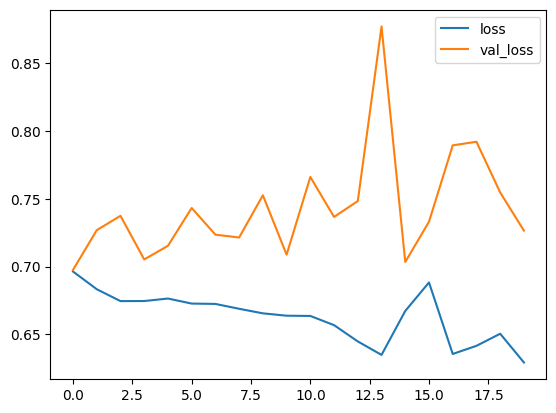

In [99]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [100]:
# Building Residual Network of ResNet
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization
from keras.layers import ReLU, Add, GlobalAveragePooling2D, Dense,MaxPooling2D

In [101]:
def res_block(input_shape, filters, strides=1):
    #
    shortcut = input_shape

    x = Conv2D(filters, (1,1), strides=1, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters*4, (1,1), padding='same')(x)
    x = BatchNormalization()(x)
    # Skip connection
    if strides !=1 or shortcut.shape[-1]!= filters*4:
        shortcut = Conv2D(filters*4, (1,1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

In [102]:
input_shape = Input(shape=(112,112,3))

# Build a simple ResNet with two residual blocks
x = Conv2D(64, (7,7), strides=2, padding='same')(input_shape)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(2,2)(x)
x = res_block(x, filters=64, strides=1)
x = res_block(x, filters=64, strides=1)
x = MaxPooling2D(2,2)(x)
x = res_block(x, filters=128, strides=1)
x = res_block(x, filters=128, strides=1)
x = MaxPooling2D(2,2)(x)
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)

In [103]:
model_2 = Model(inputs=input_shape, outputs=output)

In [104]:
model_2.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 56, 56, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 56, 56, 64)   256         conv2d_63[0][0]                  
__________________________________________________________________________________________________
re_lu_13 (ReLU)                 (None, 56, 56, 64)   0           batch_normalization_15[0][0]     
______________________________________________________________________________________

In [105]:
# Compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [106]:
history = model_2.fit(x_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
1/1 [==============================] - 0s 355ms/step - loss: 1.1062 - accuracy: 0.4167 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 58ms/step - loss: 0.5622 - accuracy: 0.8333 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 52ms/step - loss: 0.9231 - accuracy: 0.5833 - val_loss: 0.6857 - val_accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 0s 52ms/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 0.6862 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 0s 54ms/step - loss: 0.0565 - accuracy: 1.0000 - val_loss: 0.6858 - val_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.6851 - val_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 0s 51ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.6850 - val_accuracy: 0.5000
Epoch 8/20
1/1 [==========

In [107]:
# Evaluate the model on the test set
test_loss, test_acc = model_1.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

1/1 [==============================] - 0s 1ms/step - loss: 0.7450 - accuracy: 0.3750
Test accuracy: 0.375
Test loss: 0.7449890971183777


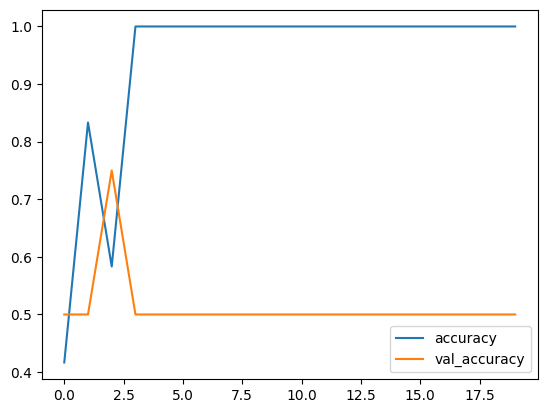

In [108]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

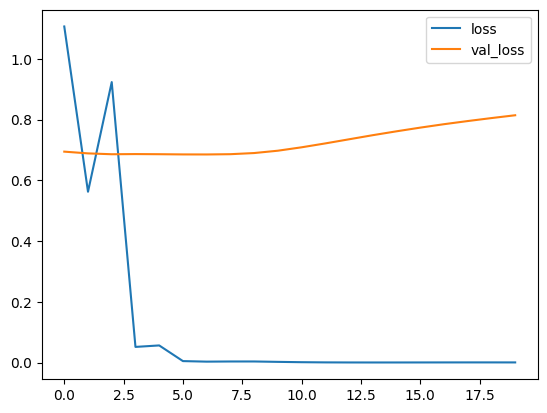

In [109]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [110]:
concatenated_output= concatenate([model_1.output, model_2.output])

In [111]:
x = Dense(100, activation='relu')(concatenated_output)
x = Dense(50, activation='relu')(x)
ensemble_model= Dense(2, activation='relu')(x)

In [112]:
#Build the ensemble model
model = Model(inputs=[model_1.input, model_2.input] , outputs= ensemble_model)

In [113]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [114]:
# Display the ensemble model summary
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 56, 56, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 56, 56, 64)   256         conv2d_63[0][0]                  
__________________________________________________________________________________________________
re_lu_13 (ReLU)                 (None, 56, 56, 64)   0           batch_normalization_15[0][0]     
______________________________________________________________________________________

In [115]:
# Train the ensemble model
history = model.fit([x_train, x_train], y_train, epochs=20, validation_split=0.2)

Epoch 1/20
1/1 [==============================] - 1s 584ms/step - loss: 5.5396 - accuracy: 0.5833 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 148ms/step - loss: 9.4022 - accuracy: 0.4167 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 150ms/step - loss: 9.4022 - accuracy: 0.4167 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 149ms/step - loss: 9.4022 - accuracy: 0.4167 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 0s 149ms/step - loss: 9.4022 - accuracy: 0.4167 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 0s 152ms/step - loss: 9.4022 - accuracy: 0.4167 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 0s 150ms/step - loss: 9.4022 - accuracy: 0.4167 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 8/20
1/1 [====

In [116]:
# Evaluate the ensemble model on the test set
test_loss_ensemble, test_acc_ensemble = model.evaluate([x_test,x_test], y_test)
print("Ensemble Test accuracy:", test_acc_ensemble)
print("Ensemble Test loss:", test_loss_ensemble)

1/1 [==============================] - 0s 997us/step - loss: 6.0443 - accuracy: 0.6250
Ensemble Test accuracy: 0.625
Ensemble Test loss: 6.044285774230957


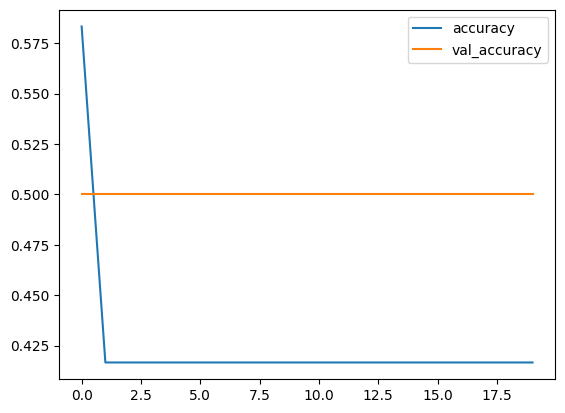

In [117]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

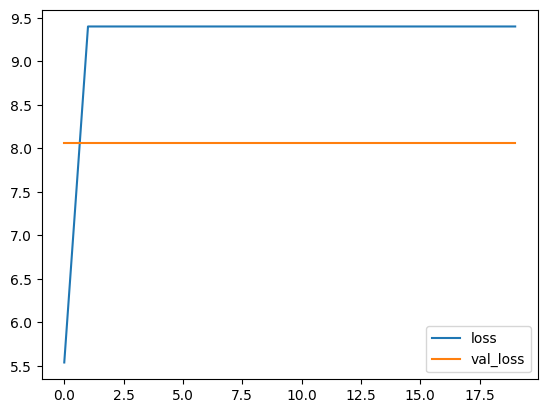

In [118]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()